In [1]:
import os
import torch
import yaml
from pathlib import Path
import random
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import plotly.graph_objects as go
from torch.utils.data import Dataset

from nerfstudio.configs import base_config as cfg
from nerfstudio.configs.method_configs import method_configs
from nerfstudio.data.dataparsers.nerfosr_dataparser import NeRFOSR, NeRFOSRDataParserConfig
from nerfstudio.pipelines.base_pipeline import VanillaDataManager
from nerfstudio.field_components.field_heads import FieldHeadNames
from nerfstudio.cameras.rays import RayBundle, RaySamples, Frustums
from nerfstudio.utils.colormaps import apply_depth_colormap
from nerfstudio.field_components.encodings import SHEncoding, NeRFEncoding
import tinycudann as tcnn

from reni_neus.models.reni_neus_model import RENINeuSFactoModelConfig, RENINeuSFactoModel
from reni_neus.utils.utils import look_at_target, random_points_on_unit_sphere
from reni_neus.data.datamanagers.reni_neus_datamanager import RENINeuSDataManagerConfig, RENINeuSDataManager
from reni_neus.configs.ddf_config import DirectionalDistanceField
from reni_neus.configs.reni_neus_config import RENINeuS
from reni_neus.utils.utils import find_nerfstudio_project_root, rot_z

project_root = find_nerfstudio_project_root(Path(os.getcwd()))
# set current working directory to nerfstudio project root
os.chdir(project_root)

# setup config
test_mode = 'test'
world_size = 1
local_rank = 0
device = 'cuda:0'

reni_neus_config = RENINeuS
reni_neus_config.config.load_dir = Path('/workspace/outputs/reni-neus/reni-neus/2023-11-09_141636/nerfstudio_models')
reni_neus_config.config.load_step = 95000

trainer = reni_neus_config.config.setup(local_rank=local_rank, world_size=world_size)
trainer.setup(test_mode=test_mode)
pipeline = trainer.pipeline
datamanager = pipeline.datamanager
model = pipeline.model
model = model.eval()

[09:41:31] Saving checkpoints to: outputs/reni-neus/reni-neus/{timestamp}/nerfstudio_models               ]8;id=945215;file:///workspace/nerfstudio/engine/trainer.py\trainer.py]8;;\:]8;id=957318;file:///workspace/nerfstudio/engine/trainer.py#134\134]8;;\

Setting up training dataset...

Caching all 160 images.

Output()

Setting up evaluation dataset...

Caching all 95 images.

Output()

Caching all 95 images.

Output()

╭─────────────────────────────────────────── Viewer ───────────────────────────────────────────╮
│        ╷                                                                                     │
│   HTTP │ ]8;id=639176;https://viewer.nerf.studio/versions/23-05-15-1/?websocket_url=ws://localhost:7007\https://viewer.nerf.studio/versions/23-05-15-1/?websocket_url=ws://localhost:7007]8;;\   │
│        ╵                                                                                     │
╰──────────────────────────────────────────────────────────────────────────────────────────────╯

[NOTE] Not running eval iterations since only viewer is enabled.
Use --vis {wandb, tensorboard, viewer+wandb, viewer+tensorboard} to run with eval.

Done loading Nerfstudio checkpoint from 
/workspace/outputs/reni-neus/reni-neus/2023-11-09_141636/nerfstudio_models/step-000095000.ckpt

Disabled comet/tensorboard/wandb event writers

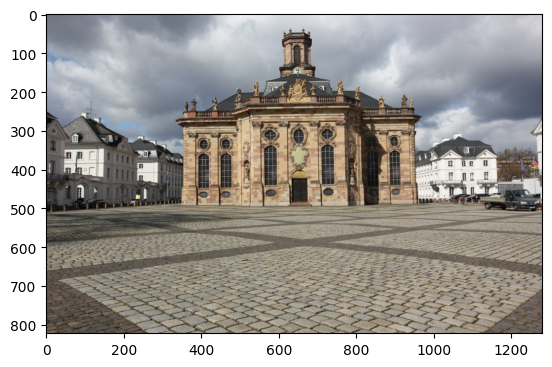

In [2]:
image_batch = datamanager.train_image_dataloader[100]
ray_bundle = datamanager.train_dataset.cameras.generate_rays(camera_indices=image_batch['image_idx'], keep_shape=True)
ray_bundle = ray_bundle.to(device)
plt.imshow(image_batch['image'].cpu().numpy())

In [3]:
model.viewing_training_image = True
model_output = model.get_outputs_for_camera_ray_bundle(camera_ray_bundle=ray_bundle, show_progress=True)
model.viewing_training_image = False

Output()

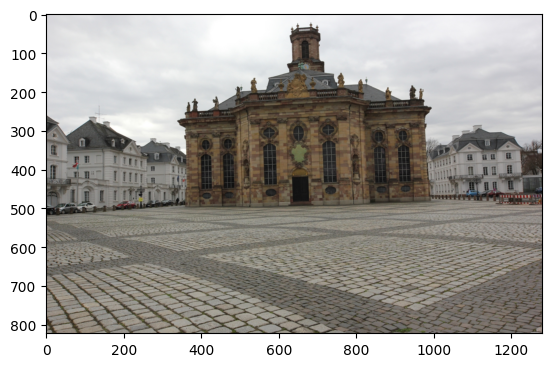

In [ ]:
plt.imshow(model_output['rgb'].cpu().numpy())

In [ ]:
plt.imshow(model_output['hdr_illumination_colours'].cpu().numpy())

KeyError: 'hdr_illumination_colours'

In [ ]:
idx, ray_bundle, batch = datamanager.next_eval_image(0)
# move all batch elements to device if tensor
batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}

model_output = {}
model_output['rgb'] = batch['image'].to(model.device)
model_output['accumulation'] = batch["mask"][..., 1:2].to(model.device)
model_output['depth'] = batch['image'][..., 0:1].to(model.device)
model_output['prop_depth_0'] = batch['image'][..., 0:1].to(model.device)
model_output['prop_depth_1'] = batch['image'][..., 0:1].to(model.device)
model_output['hdr_background_colours'] = torch.zeros((64, 128, 3)).to(model.device)
model_output['albedo'] = batch['image'].to(model.device)
model_output['normal'] = batch['image'].to(model.device)
metrics_dict, images_dict = model.get_image_metrics_and_images(outputs=model_output, batch=batch)

/home/user/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


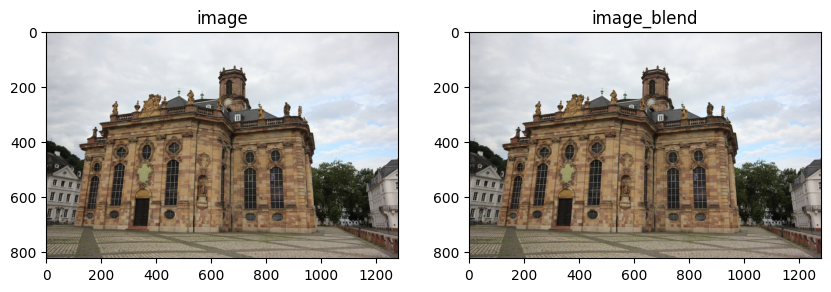

In [ ]:
rgb = model_output["rgb"]
image = batch["image"].to(model.device)
image_blend = model.renderer_rgb.blend_background(image)

# plot both image and image_blend
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image.cpu().numpy())
plt.title("image")
plt.subplot(1, 2, 2)
plt.imshow(image_blend.cpu().numpy())
plt.title("image_blend")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


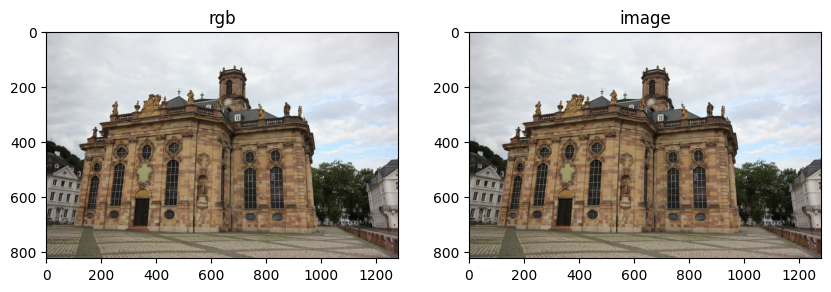

In [ ]:
# add a small amount of noise to rgb
rgb = rgb + torch.randn_like(rgb) * 0.001
# plot rgb and image
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(rgb.cpu().numpy())
plt.title("rgb")
plt.subplot(1, 2, 2)
plt.imshow(image.cpu().numpy())
plt.title("image")
plt.show()

In [ ]:
batch["mask"][..., 0:1].shape, rgb.shape, batch["mask"][..., 0:1].dtype, rgb.dtype

(torch.Size([823, 1280, 1]),
 torch.Size([823, 1280, 3]),
 torch.float32,
 torch.float32)

In [ ]:
unique_mask_values = torch.unique(batch["mask"][..., 0:1])
print(unique_mask_values)

tensor([  0., 255.], device='cuda:0')


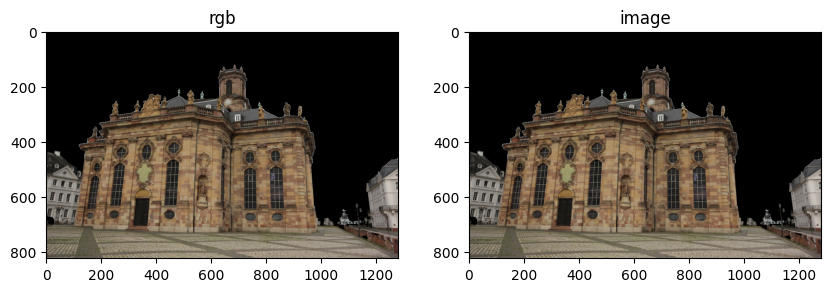

In [ ]:
if model.config.eval_latent_optimise_method in ["nerf_osr_holdout", "nerf_osr_envmap"]:
    # we need to only compute metrics within the mask
    mask = batch["mask"][..., 0:1] # this will be the nerfosr test masks provided, baiscally its only using building for metrics
    mask = mask.to(model.device)
    rgb_masked = rgb * mask.expand_as(rgb)
    image_masked = image * mask.expand_as(image)

# plot rgb and image
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(rgb_masked.cpu().numpy())
plt.title("rgb")
plt.subplot(1, 2, 2)
plt.imshow(image_masked.cpu().numpy())
plt.title("image")
plt.show()

In [ ]:
if model.config.eval_latent_optimise_method in ["nerf_osr_holdout", "nerf_osr_envmap"]:
    # we need to only compute metrics within the mask
    mask = batch["mask"][..., 0:1] # this will be the nerfosr test masks provided, baiscally its only using building for metrics
    mask = mask.to(model.device)
    rgb = rgb * mask
    image = image * mask

# Switch images from [H, W, C] to [1, C, H, W] for metrics computations
image = torch.moveaxis(image, -1, 0)[None, ...]
rgb = torch.moveaxis(rgb, -1, 0)[None, ...]

psnr = model.psnr(image, rgb)

In [ ]:
psnr

tensor(14.4842, device='cuda:0')

In [ ]:
image_idx, camera_ray_bundle, batch = datamanager.next_eval_image(1)

In [ ]:
camera_ray_bundle.camera_indices[:, :, 0]

tensor([[2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        ...,
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2]], device='cuda:0')

In [ ]:
batch['image_idx']

0

In [ ]:
camera_ray_bundle, batch = next(datamanager.iter_eval_dataloader)
batch

{'image_idx': 32,
 'image': tensor([[[0.8039, 0.8078, 0.8275],
          [0.8039, 0.8078, 0.8275],
          [0.8000, 0.8039, 0.8235],
          ...,
          [0.9255, 0.9216, 0.9451],
          [0.9333, 0.9216, 0.9490],
          [0.9333, 0.9216, 0.9490]],
 
         [[0.8039, 0.8000, 0.8235],
          [0.8039, 0.8000, 0.8235],
          [0.8000, 0.8039, 0.8235],
          ...,
          [0.9333, 0.9294, 0.9529],
          [0.9333, 0.9216, 0.9490],
          [0.9333, 0.9216, 0.9490]],
 
         [[0.8118, 0.8078, 0.8314],
          [0.8078, 0.8039, 0.8275],
          [0.8000, 0.8039, 0.8235],
          ...,
          [0.9294, 0.9255, 0.9490],
          [0.9333, 0.9216, 0.9490],
          [0.9333, 0.9216, 0.9490]],
 
         ...,
 
         [[0.5647, 0.5373, 0.4980],
          [0.5922, 0.5686, 0.5216],
          [0.6980, 0.6588, 0.6118],
          ...,
          [0.5647, 0.4784, 0.3882],
          [0.5373, 0.4588, 0.3608],
          [0.4980, 0.4196, 0.3216]],
 
         [[0.6784, 0.